# 🐝💨 Introduction to Xylo-IMU

In [1]:
# - General installation and imports
import sys
!{sys.executable} -m pip install --quiet matplotlib rich "rockpool[xylo, torch]"

# - Import numpy
import numpy as np

# - Configure matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Display images
from IPython.display import Image

# - Nice printing
from rich import print

## Overview of the Xylo-IMU design
Xylo-IMU 1 receives direct input from a MEMSIC MC3632 IMU sensor, and is designed to enable motion classification applications in real-time at low power.

The block-level outline of the chip is shown below.
A dedicated IMU interface connects to the IMU sensor via a master SPI bus, and converts motion data into streams of events.

Event-encoded motion data is transferred to a digital SNN core for inference. The results of inference, encoded as output event streams, are transmitted over an interrupt bus or slave SPI bus to an external microcontroller.

A block of control logic manages configuration and communication with the cores. Configuration and readout from Xylo-IMU is performed over a slave SPI bus.

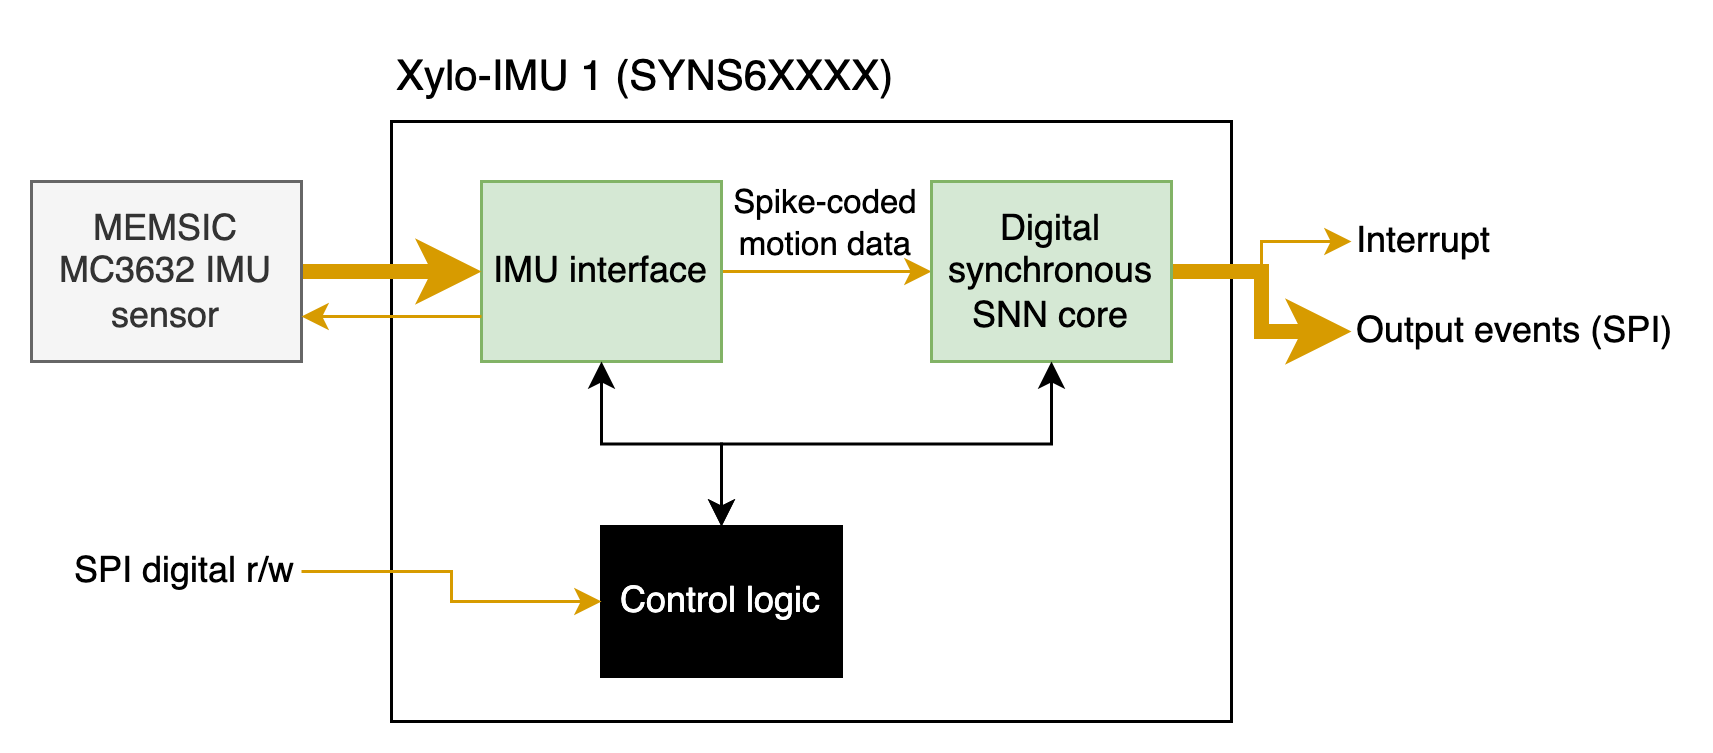

In [2]:
Image('xylo-imu-block-level.png')

## Differences from other Xylo devices
Xylo-IMU is based around the same digital integer LIF inference core as the rest of the Xylo™ family.
Xylo-IMU includes several design changes from Xylo-Audio 2 and other Xylo-family devices:

 * One synaptic state per neuron
 * 16 spiking input channels to SNN core
 * 496 hidden neurons
 * 16 spiking output channels
 * Input weight projections to up to first 128 hidden neurons
 * Output weight projection from up to 128 hidden neurons
 * Up to 512 fanout recurrent weights per hidden neuron
 * Up to 31,744 recurrent weights total

## Part I: Using the SNN inference core on Xylo-IMU


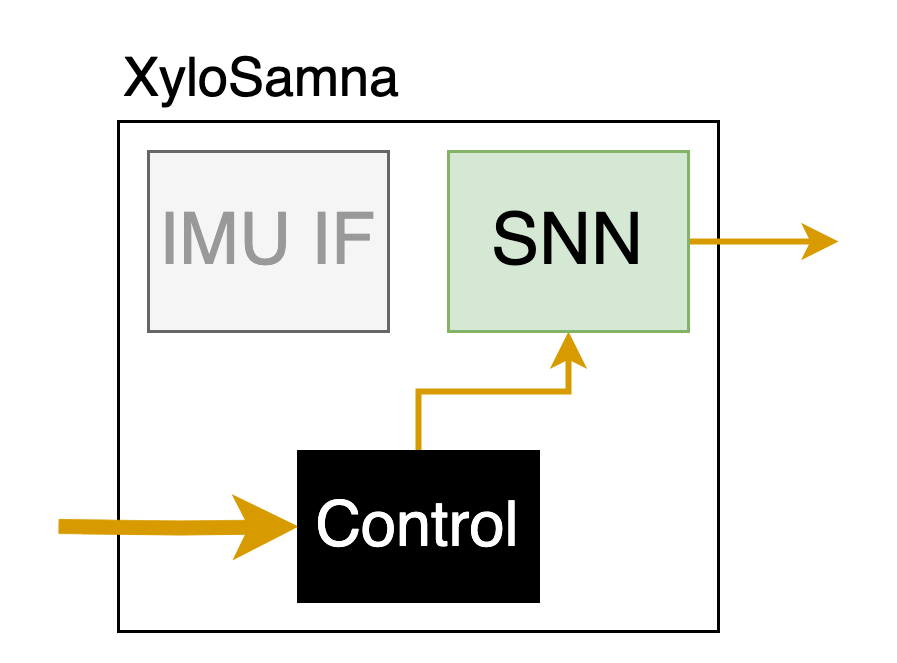

In [3]:
Image('XyloSamna.png', width=400)


### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [4]:
# - Used to build trainable models
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Modules required to interface and deploy models to the Xylo-IMU HDK
from rockpool.devices.xylo import find_xylo_hdks
from rockpool.devices.xylo.imu import XyloSamna, config_from_specification, mapper, XyloSim
import rockpool.devices.xylo.imu.xylo_imu_devkit_utils as putils
from rockpool.transform import quantize_methods as q

# - Used for plotting time series
from rockpool import TSEvent, TSContinuous

Jax was detected. Spike generation can be performed by the JIT compiled version.
__JAX_VERSION__: True: Using Jax-JIT version of spike encoding.


In [5]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [6]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [7]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use `config_from_specification()` to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

### Step 2: Deploy the network to the Xylo SNN core on a connected HDK

In [8]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, _, vers = find_xylo_hdks()
print(xylo_hdk_nodes, vers)

if len(xylo_hdk_nodes) == 0 or vers[0] != 'xylo-imu':
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

[]
[]

AssertionError: This tutorial requires a connected Xylo IMU HDK to demonstrate.

In [ ]:
# - Use the `XyloSamna` module to deploy to the inference core on the HDK
modSamna = XyloSamna(db, config, dt = dt)
print(modSamna)

XyloSamna  with shape (2, 8, 2)

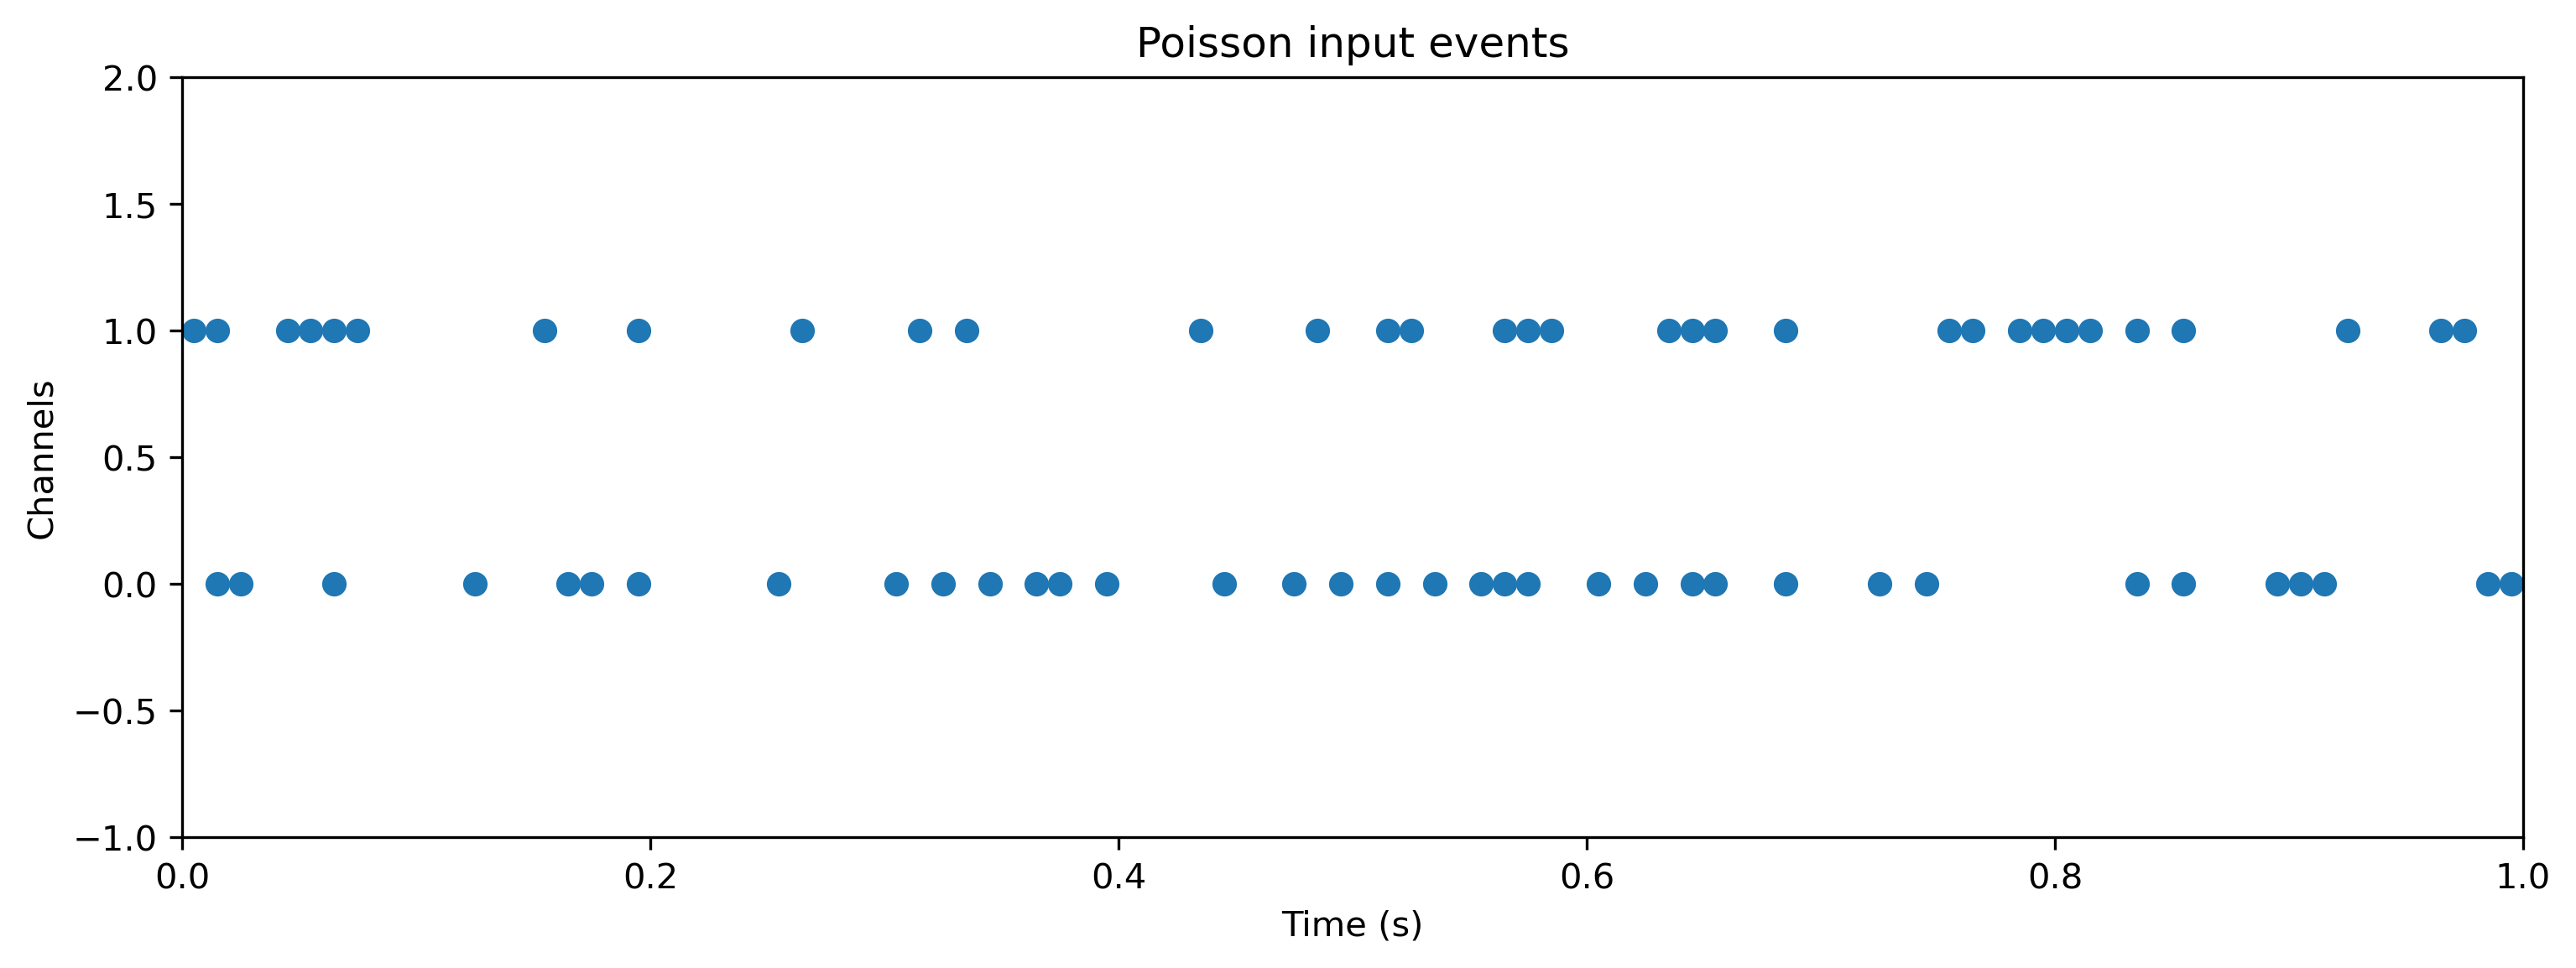

In [ ]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [ ]:
# - Evolve the network on the Xylo HDK
out, _, r_d = modSamna.evolve(input_spikes.astype(int), record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])

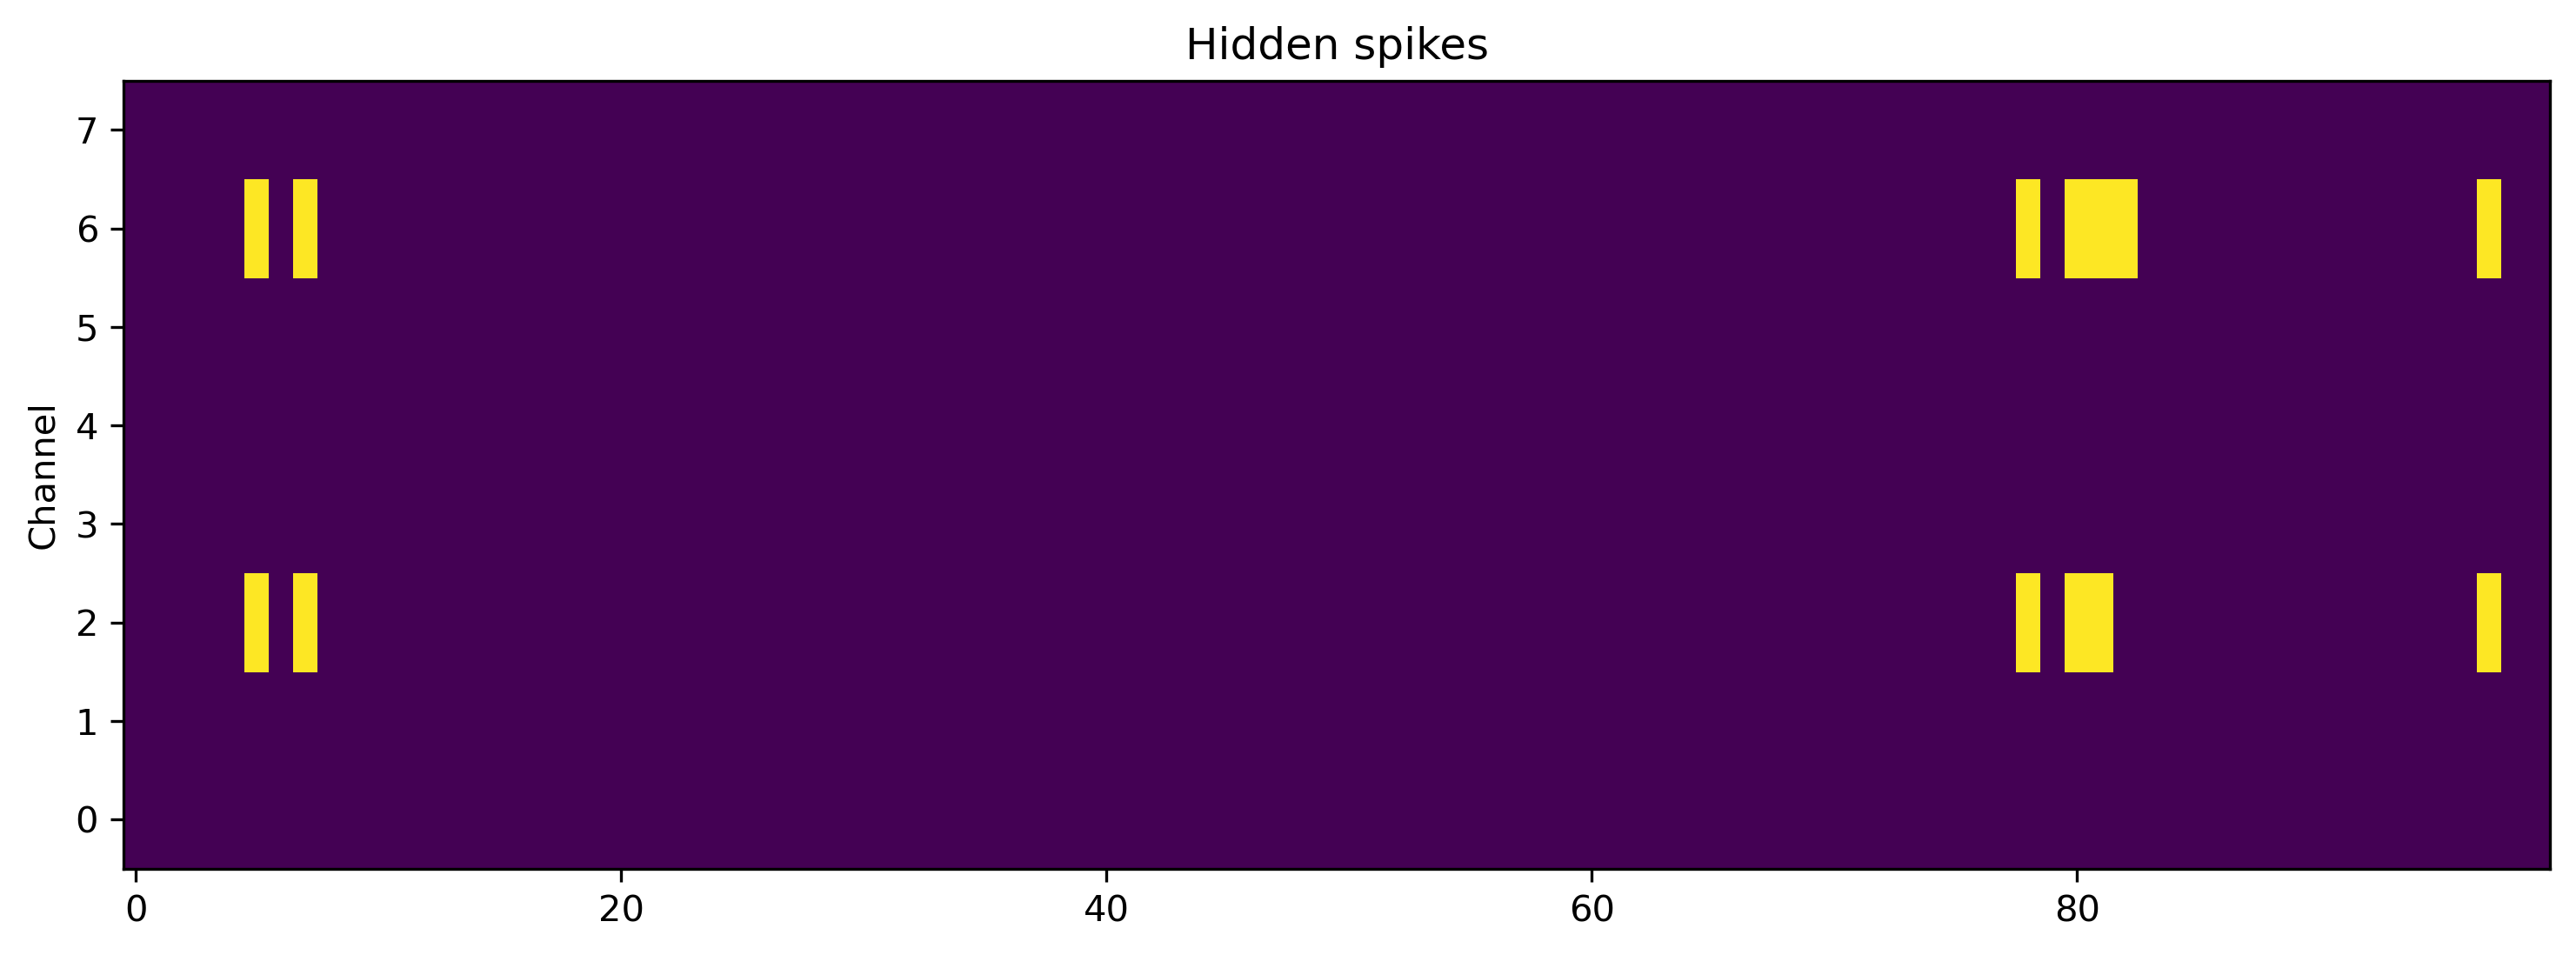

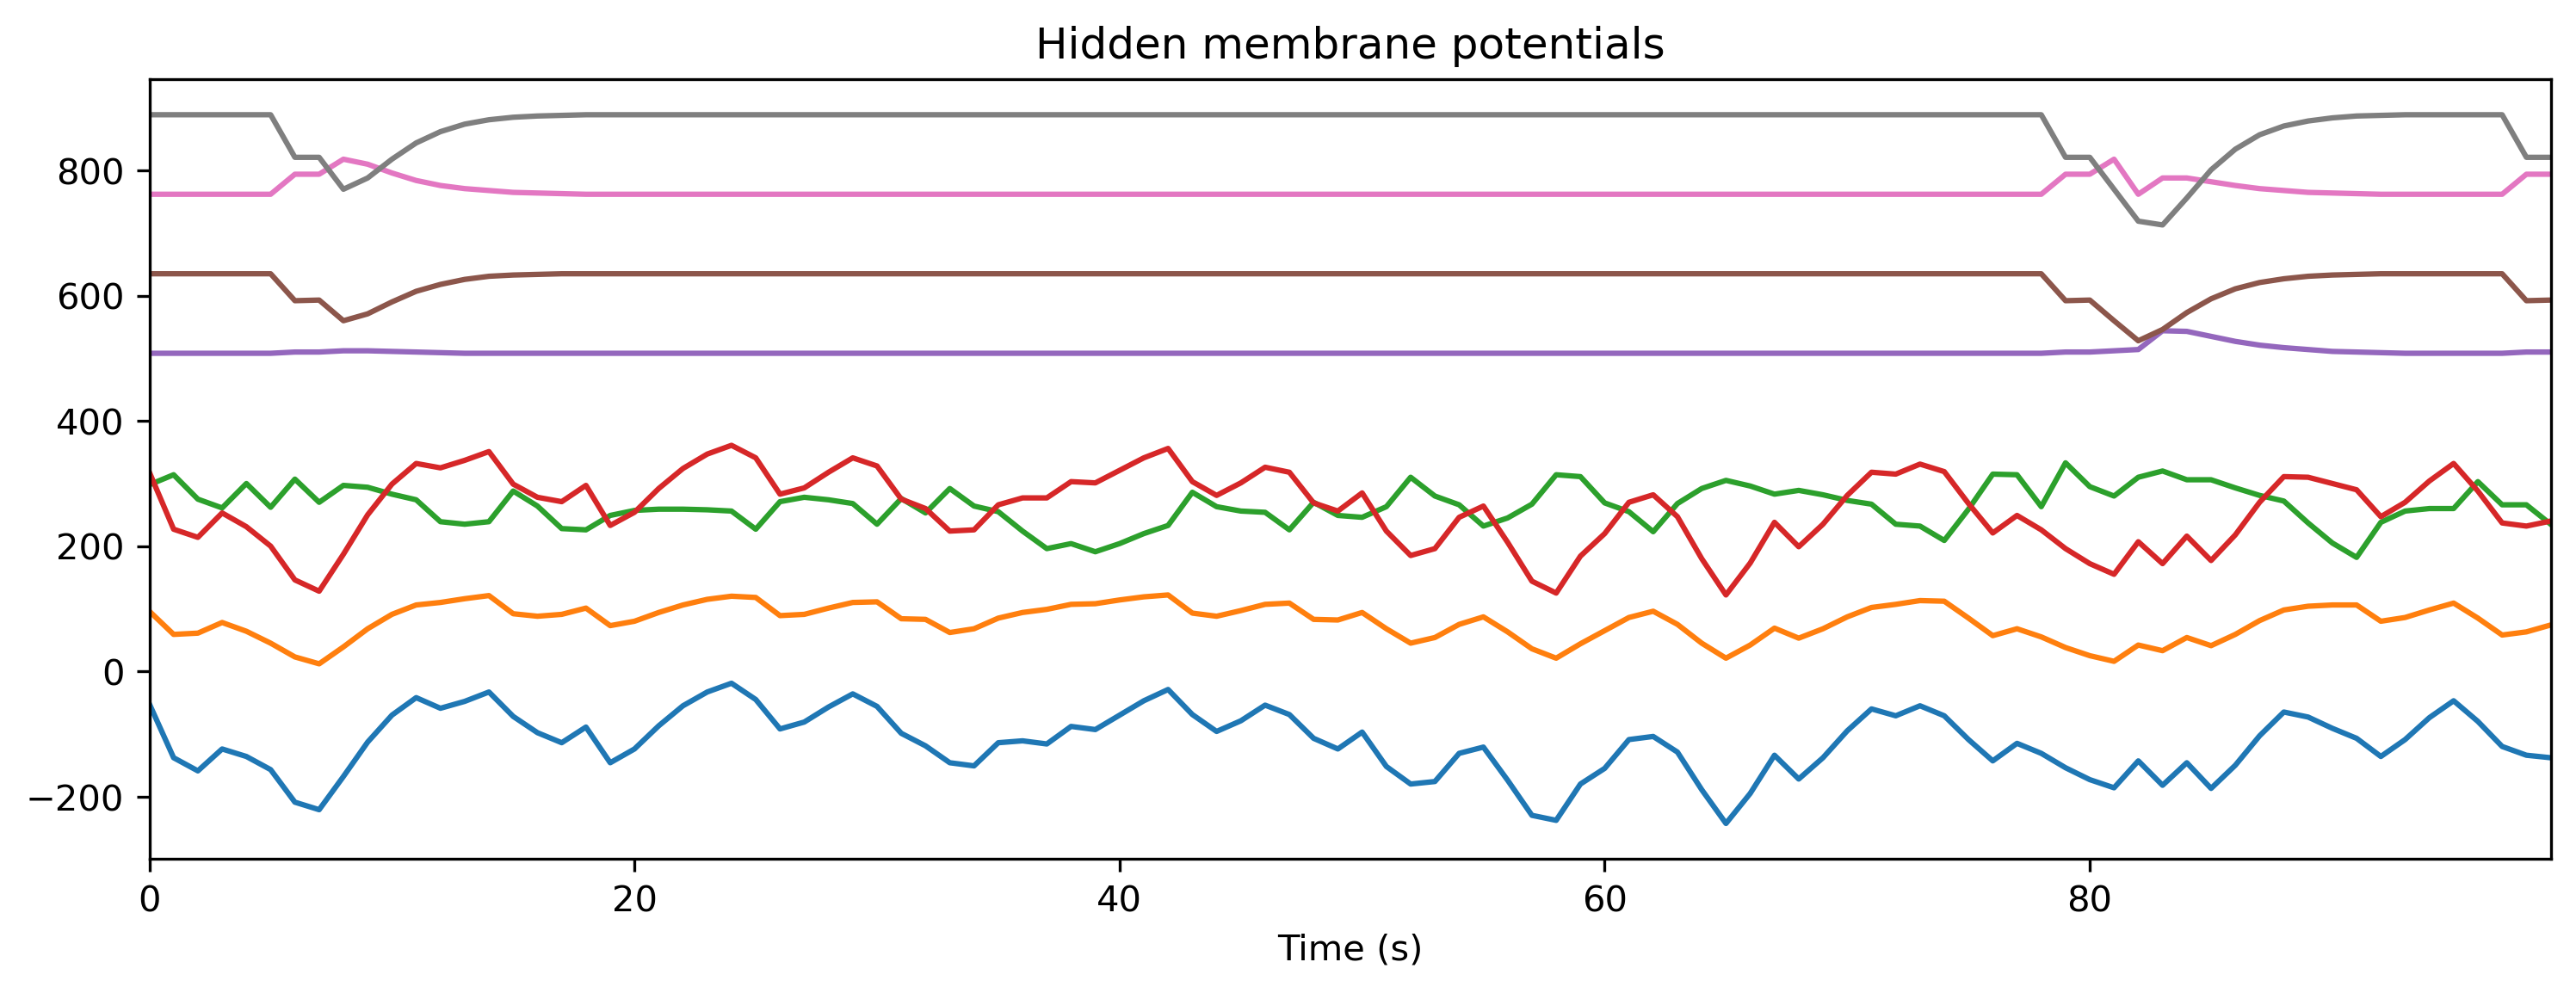

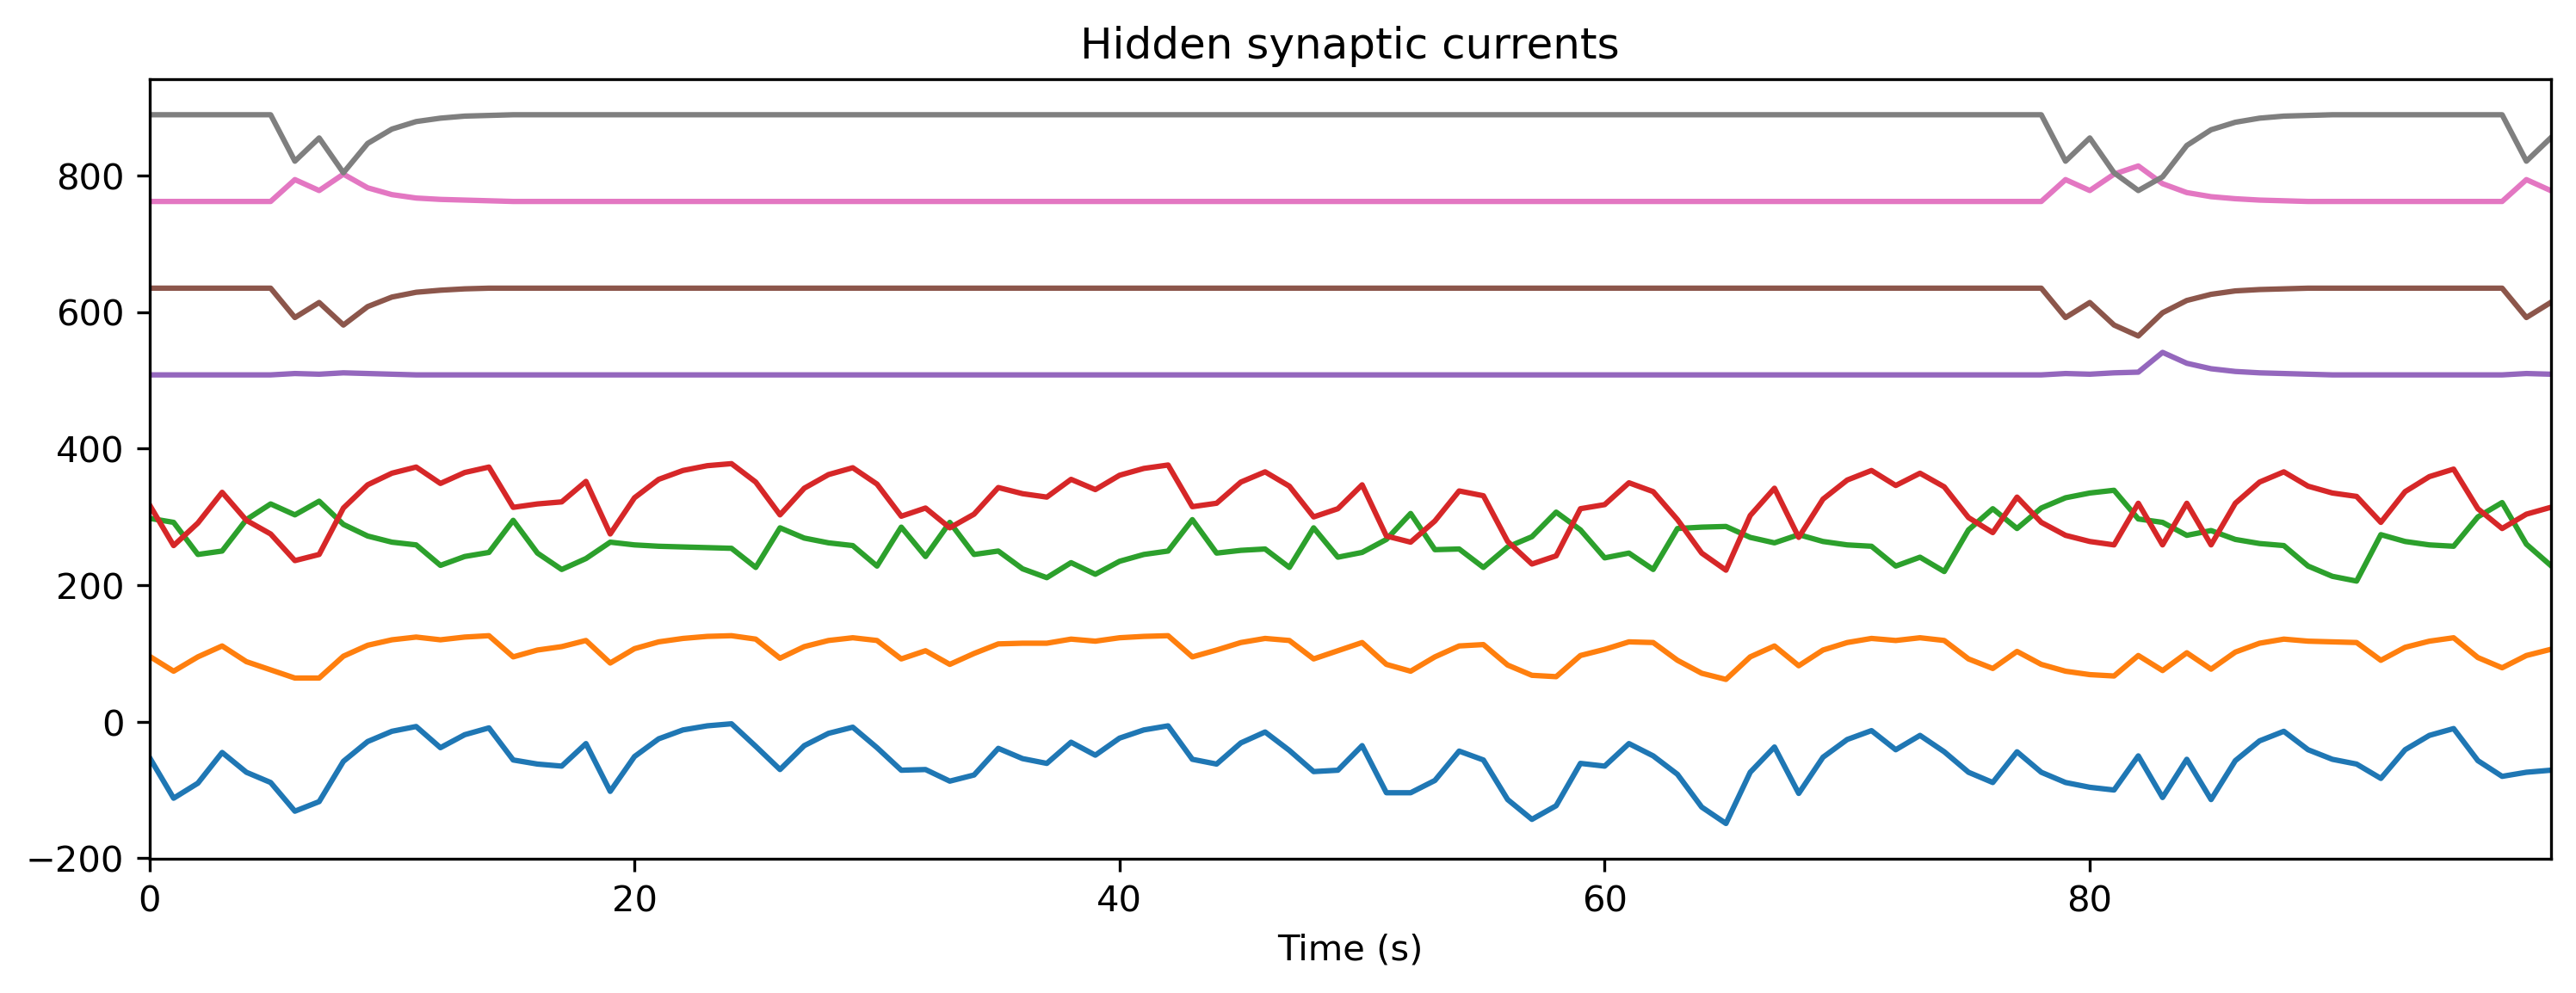

In [ ]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127);

### Step 3: Simulate the HDK using a bit-precise simulator

In [ ]:
# - Use the XyloIMUSim device simulator
modSim = XyloSim.from_config(config, dt=dt)
print(modSim)

XyloSim  with shape (16, 1000, 8)

In [ ]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])

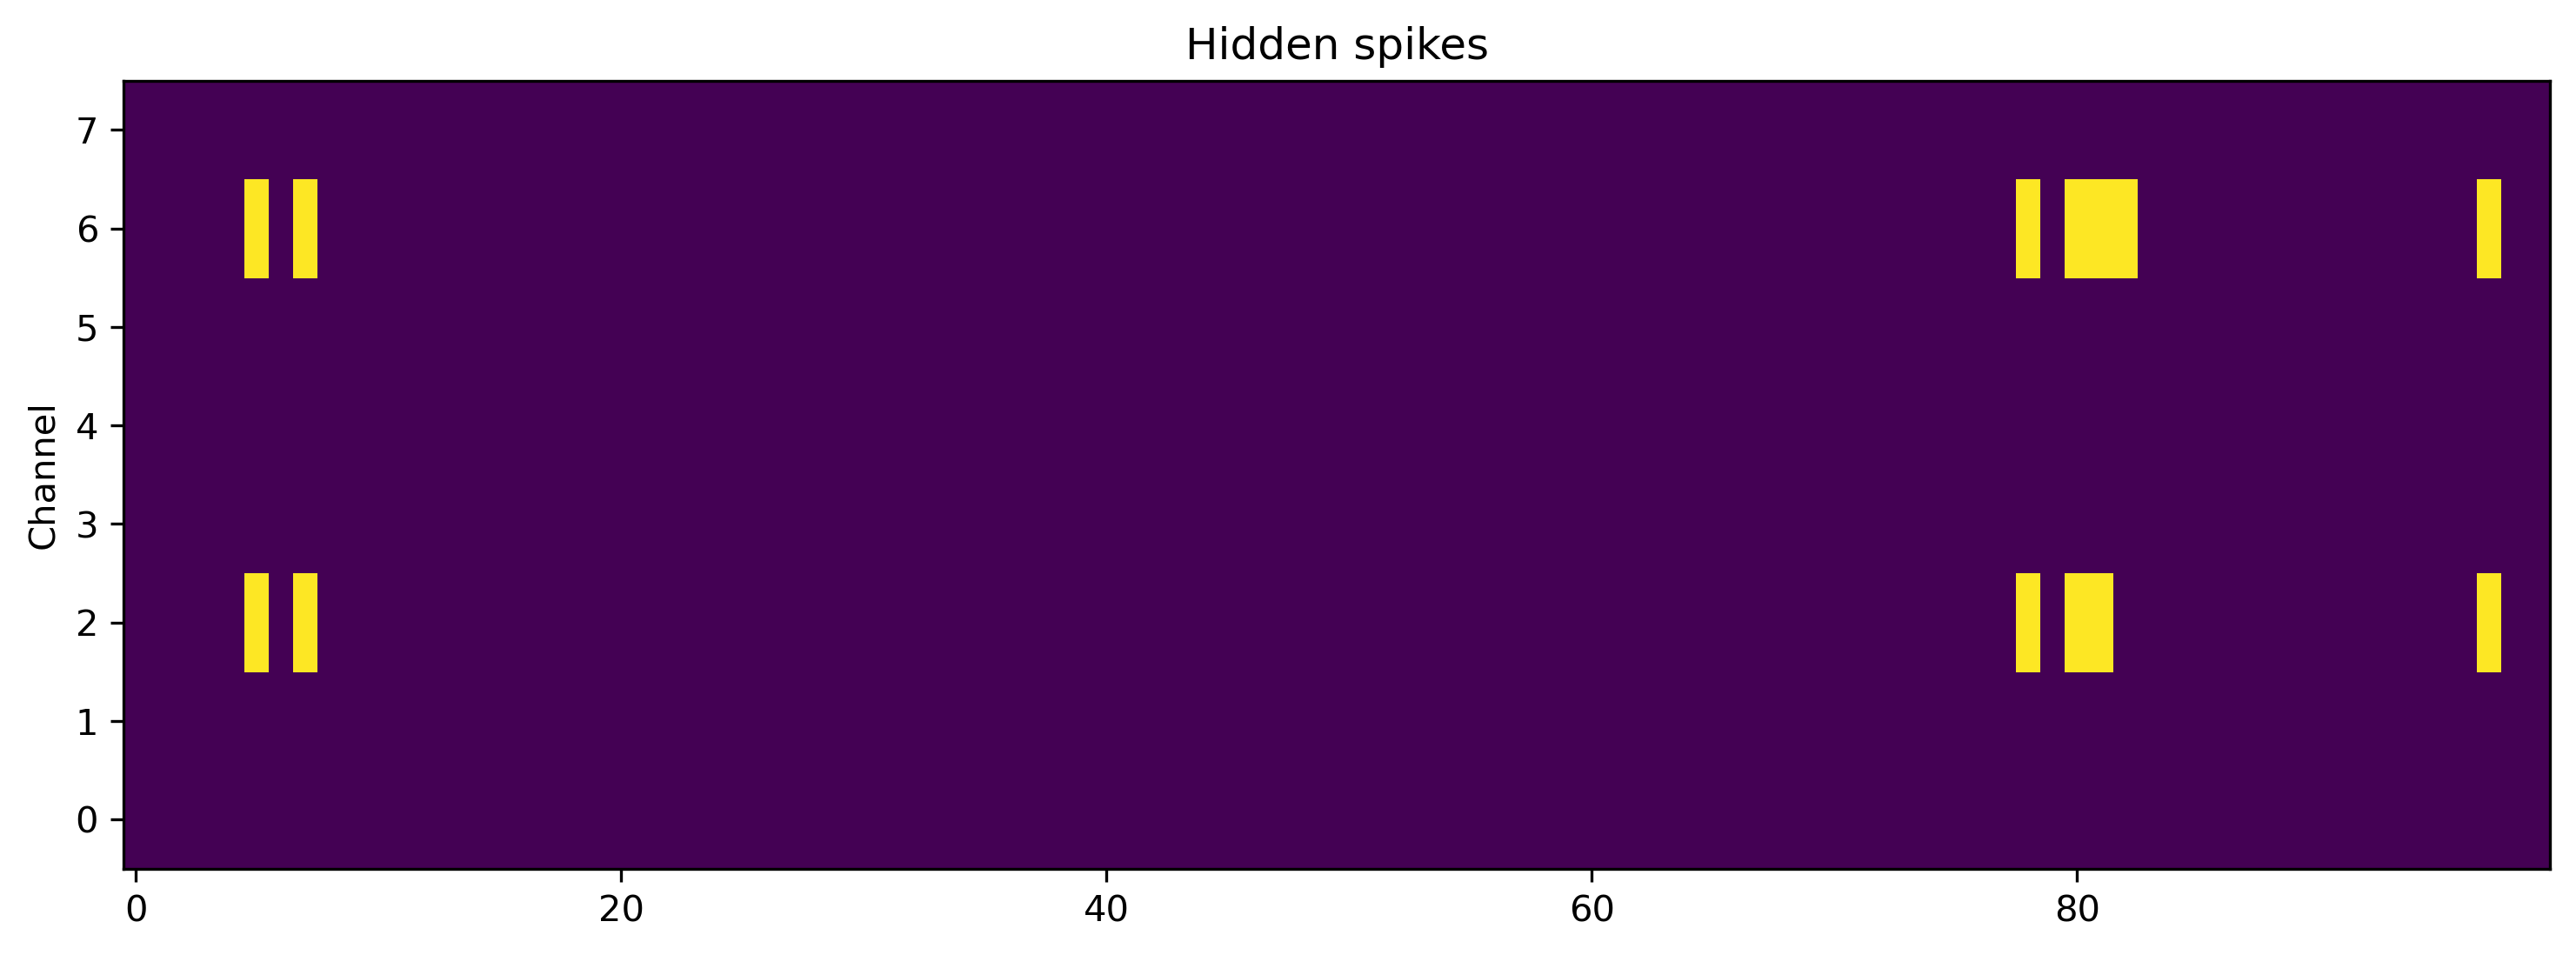

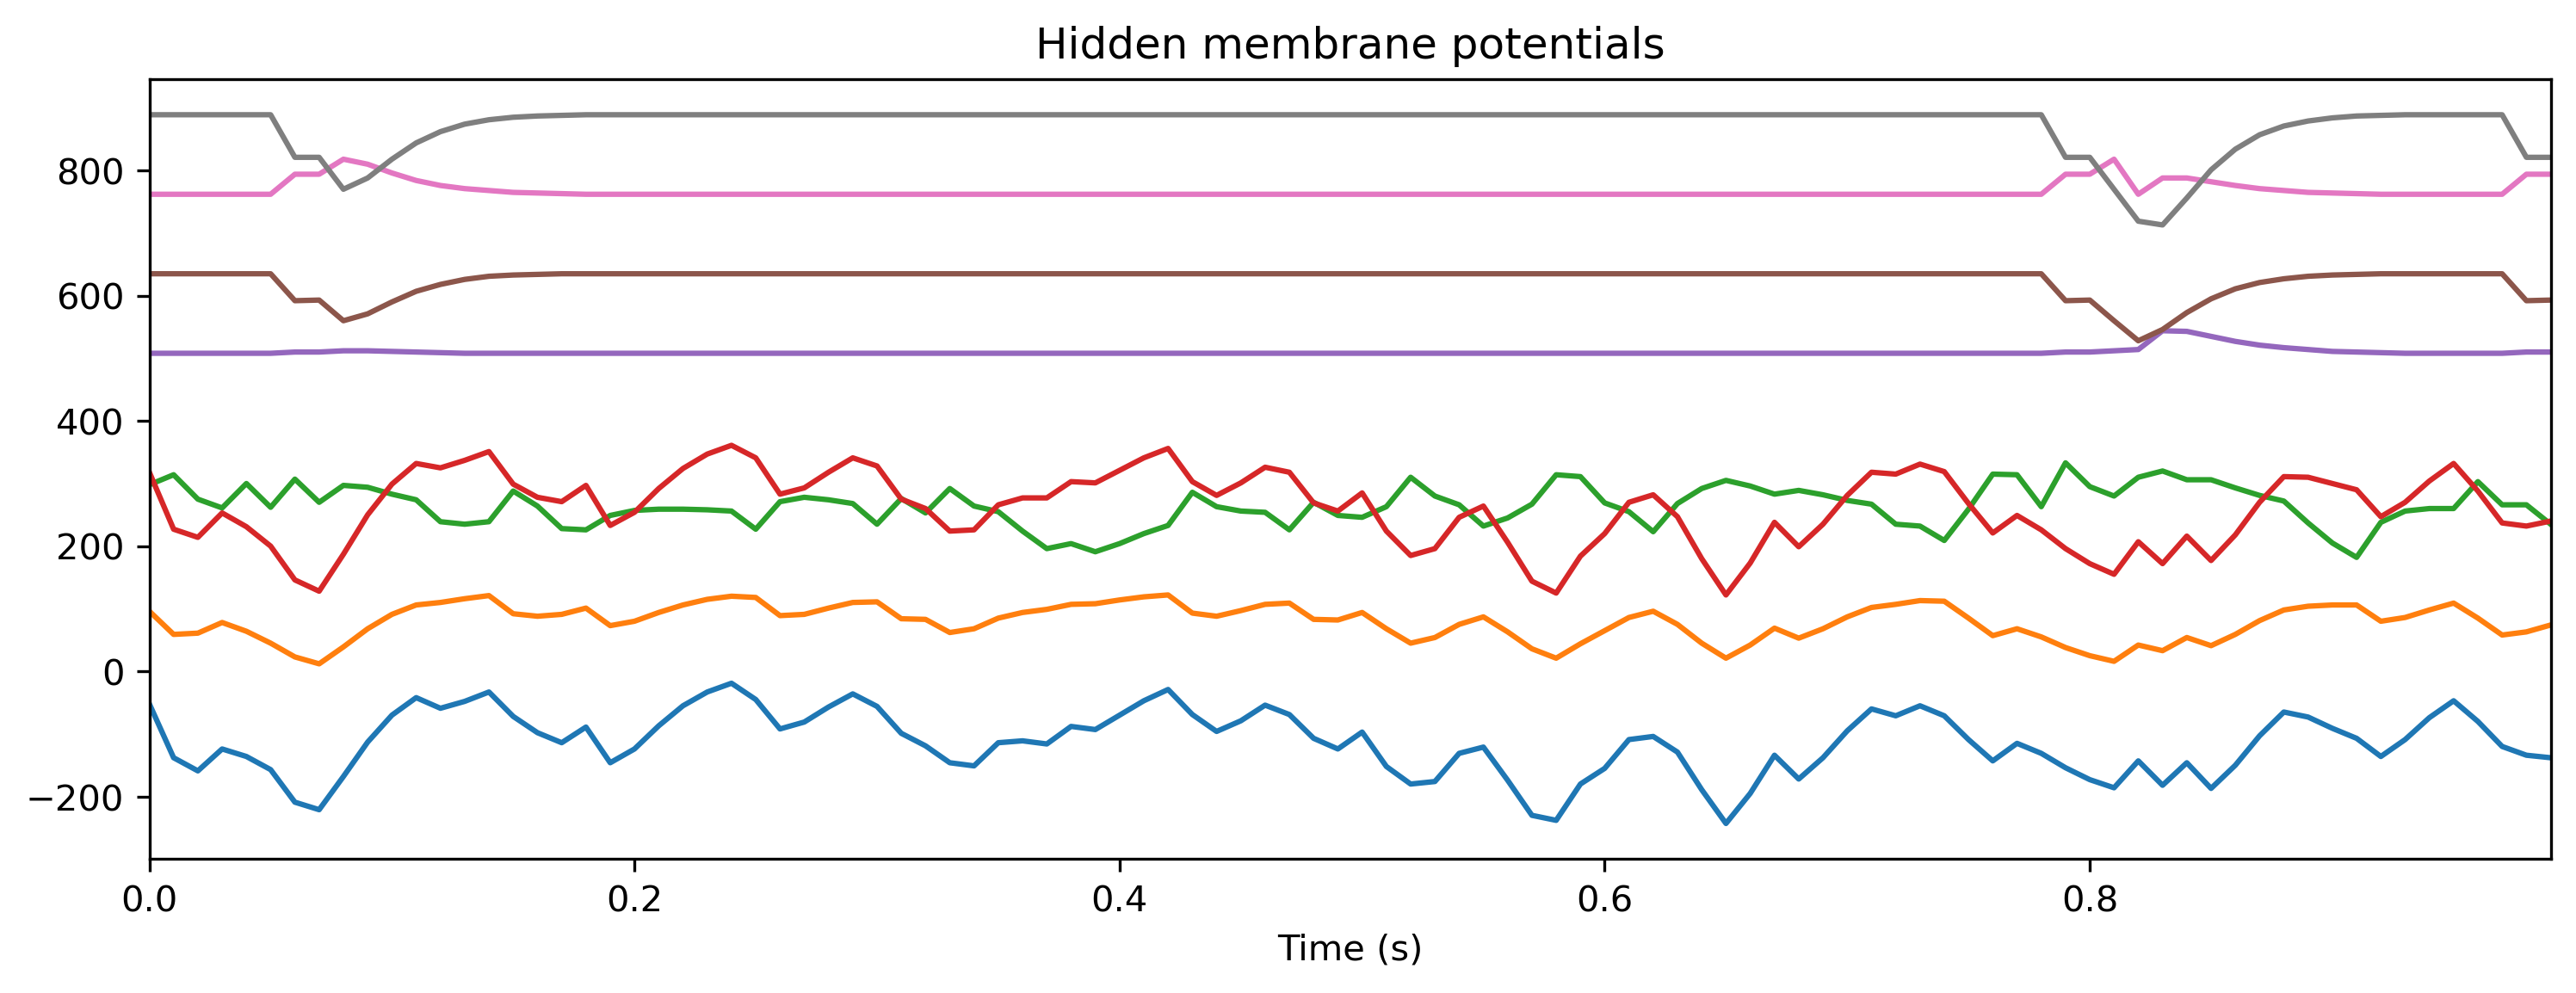

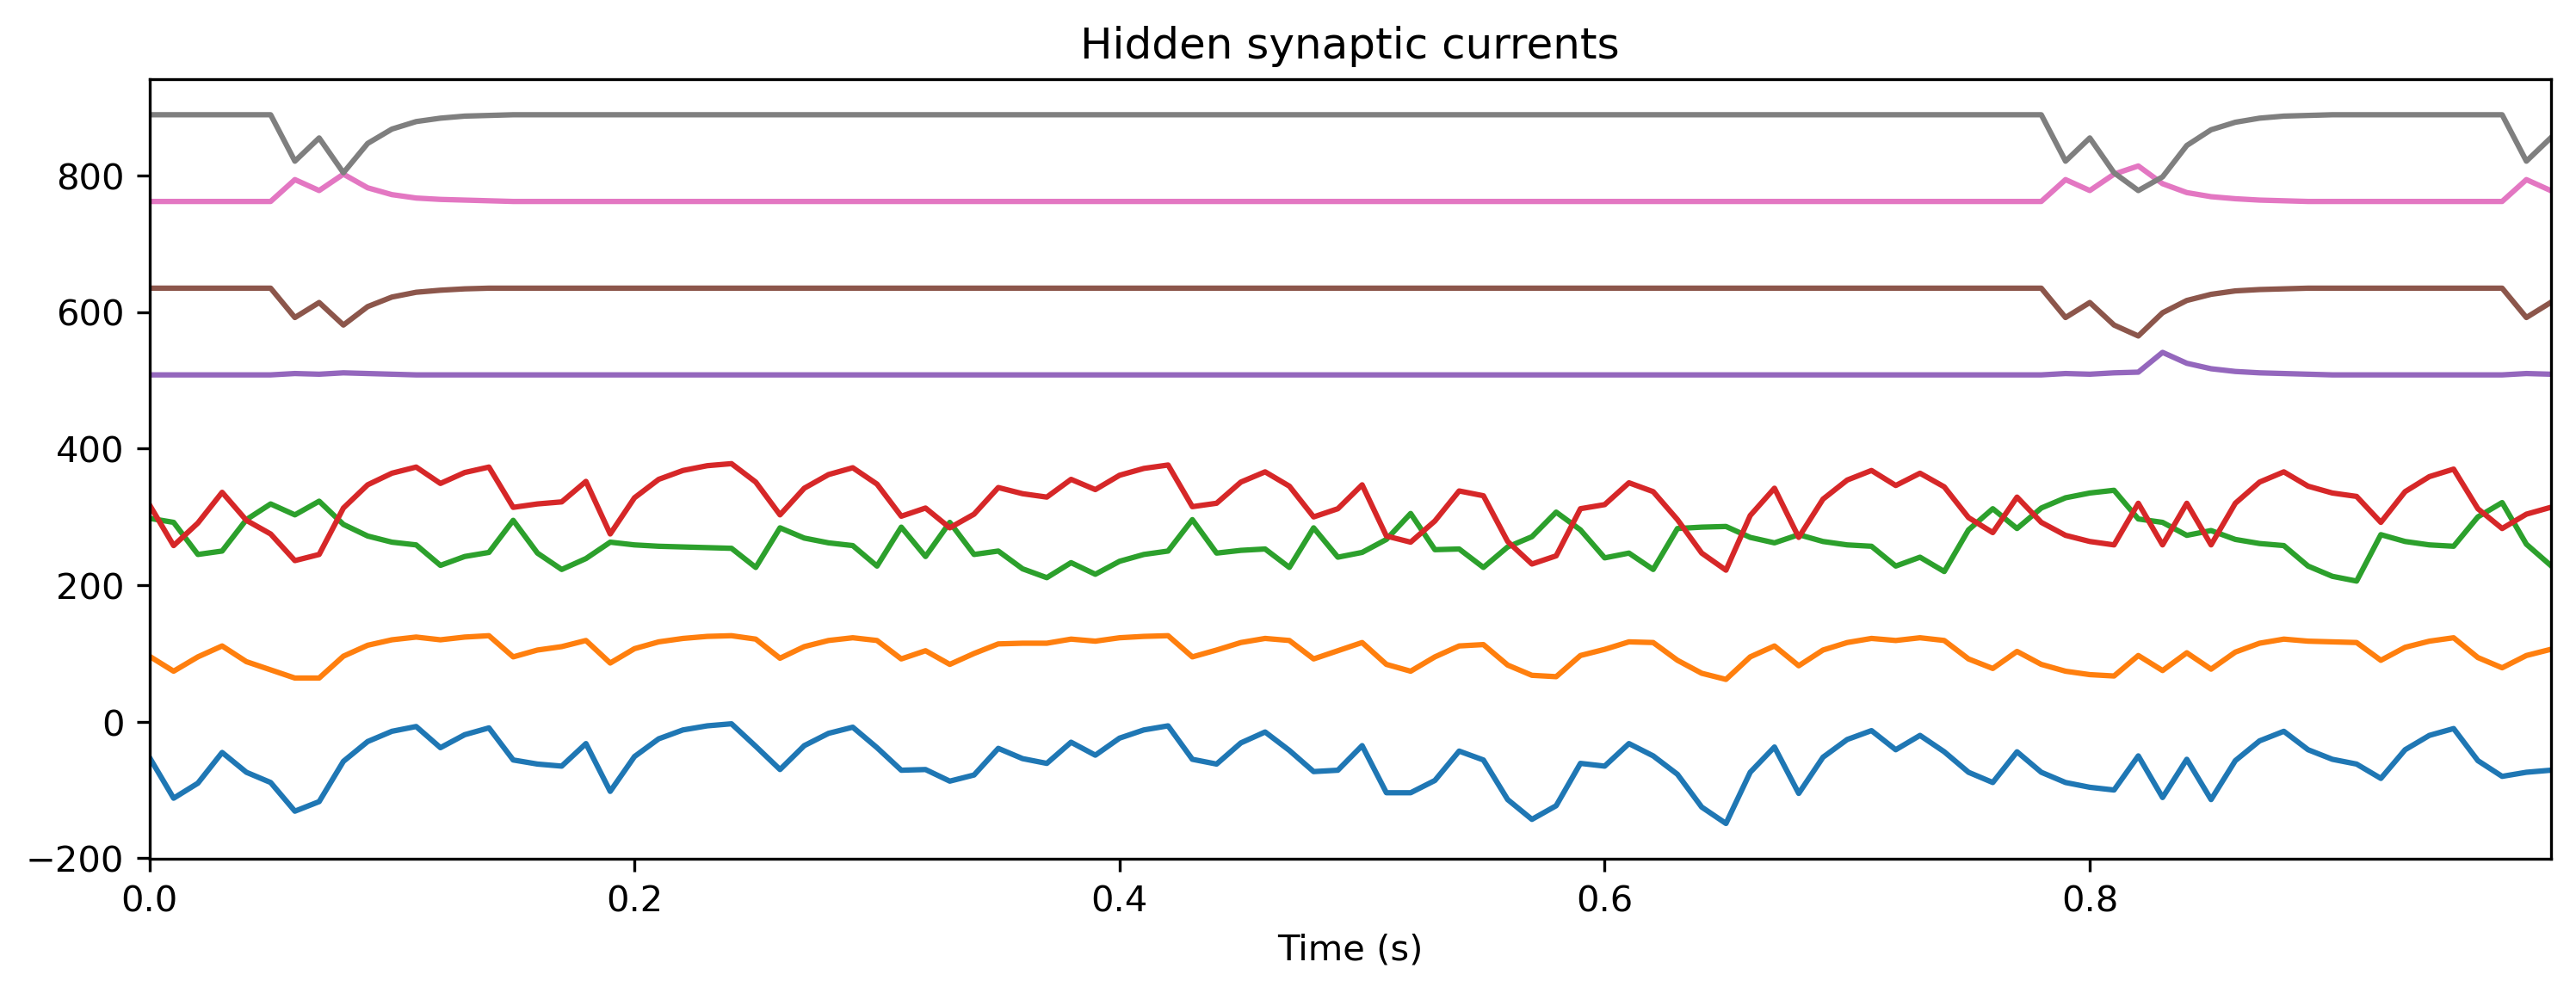

In [ ]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

## PART II: Simulation of IMU encoding interface

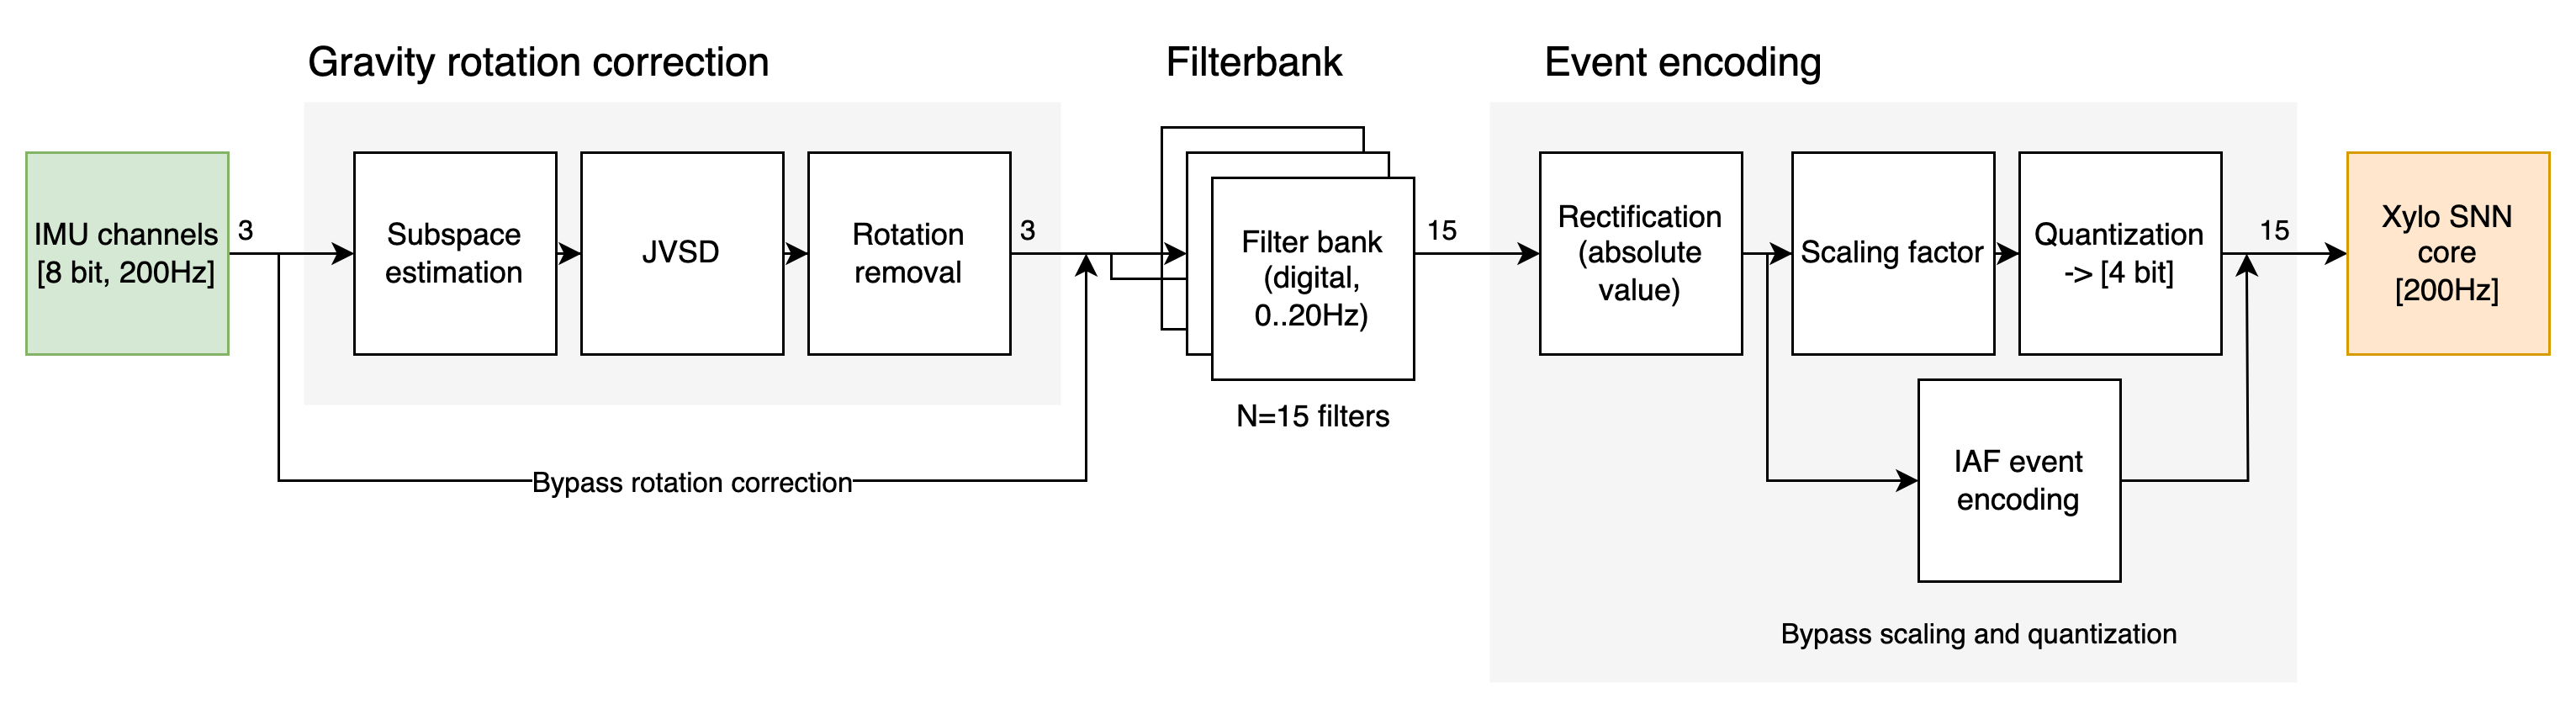

In [ ]:
Image('IMU-IF-block-level.png')

In [ ]:
# from rockpool.devices.xylo.imu import IMUIFSim

# - Load a dummy IMU sample
# input_data = np.load(data.npy)

# - Create an IMUIFSim module
# mod = IMUIFSim()

# - Test evolution and plot output
# out, _, r_d = mod(input_data, record = True)
# plt.imshow(out[0].T);

## PART III: IMU encoding interface on HW

<div class="alert alert-block alert-warning"> Use yellow boxes for examples that are not inside code cells, or use for mathematical formulas if needed. </div>

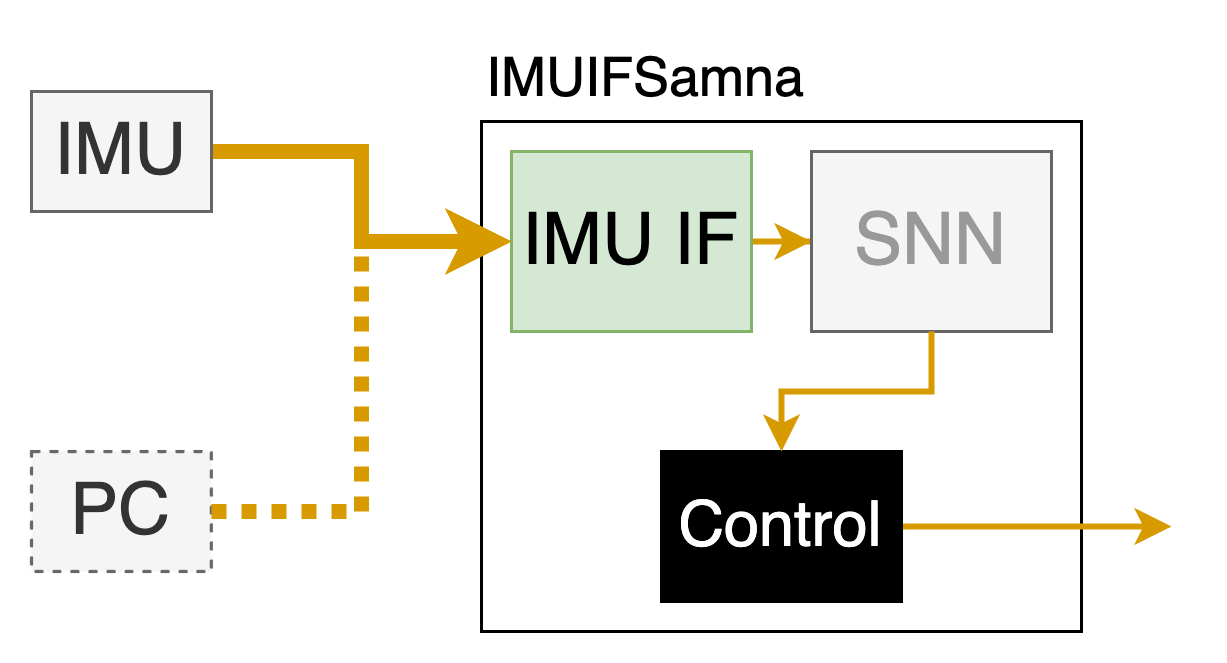

In [9]:
Image('IMUIFSamna.png', width=400)

## PART IV: Recording live IMU data

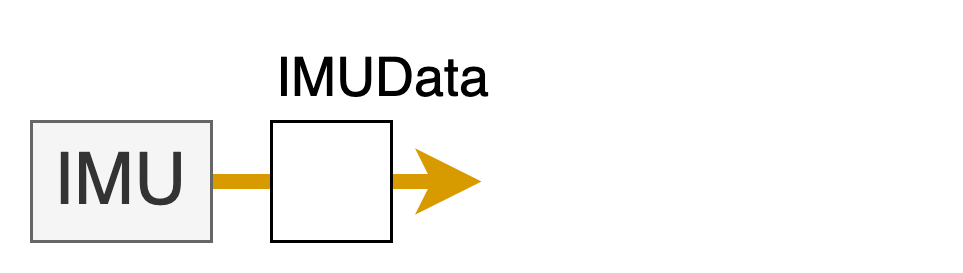

In [11]:
Image('IMUData.png', width=400)

In [ ]:
from rockpool.devices.xylo.imu import IMUData

mod = IMUData()
print(mod)

## PART XX: Real-time streaming mode

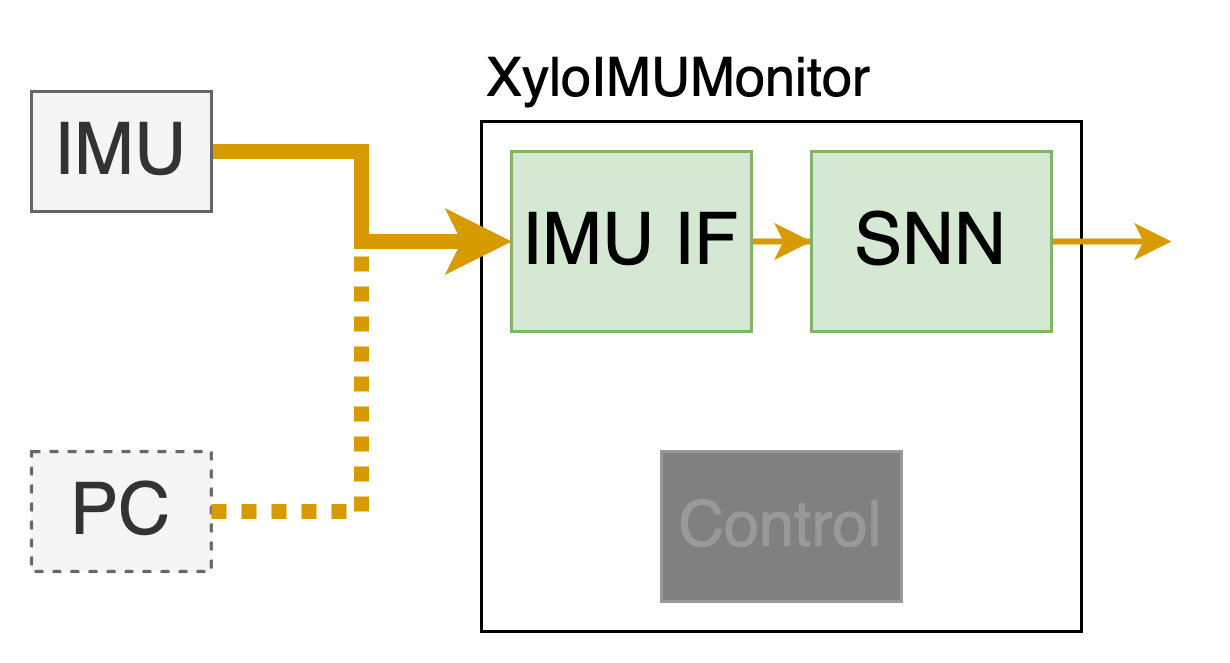

In [ ]:
Image('XyloIMUMonitor.png', width = 400)

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [ ]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [ ]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}


In [ ]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

### Step 2: Deploy the network on chip and run simulation

In [ ]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, _, vers = find_xylo_hdks()
print(xylo_hdk_nodes, vers)

if len(xylo_hdk_nodes) == 0 or vers[0] != 'xylo-imu':
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

In [ ]:
# - Use the `XyloIMUMonitor` module to deploy to the HDK, running in real time

output_mode = "Vmem"
T = 10

modMonitor = XyloIMUMonitor(device=db, config=config, dt=dt, output_mode=output_mode)

NameError: name 'XyloIMUMonitor' is not defined

In [ ]:
# - A resultList stack to store the results

class ResultList(object):
    def __init__(self, max_len=100):
        self._list = []
        self.max_len = max_len

    def reset(self):
        self._list = []

    def append(self, num):
        if len(self._list) < self.max_len:
            self._list.append(num)
        else:
            self._list[: self.max_len - 1] = self._list[1:]
            self._list[self.max_len - 1] = num

    def is_full(self):
        if len(self._list) == self.max_len:
            return True
        else:
            return False

    def counts(self, features=[]):
        count = 0
        for _ in self._list:
            if _ in features:
                count += 1
        return count

    def __len__(self):
        return len(self._list)

    def print_result(self):
        return self._list



In [ ]:
# - Draw a real time image for output channels, you can shake the Xylo IMU device while running

lines = [ResultList(max_len=10) for _ in range(Nout)]
time_base = ResultList(max_len=10)
tt = 0
t_inference = 10.


from time import time

t_start = time()

while (time() - t_start) < t_inference:
    # - Perform inference on the Xylo IMU HDK
    output, _, _ = modMonitor(input_data=np.zeros((T, Nin)))
    if output is not None:
        output = np.max(output, axis=0)
        for i in range(Nout):
            lines[i].append(output[i])

        time_base.append(tt)
        tt += 0.1
        ax_time = time_base.print_result()
        
        for i in range(Nout):
            plt.plot(ax_time, lines[i].print_result(), label=f"class{i}")

        plt.xlabel('time')
        plt.ylabel('Vmem')
        plt.legend()
        plt.pause(0.1)
        display.clear_output(wait=True)

KeyboardInterrupt: 